# Making Monthly Data

Due to the high variability in the data, it might be better to sum it over per month. This would hopefully avoid some of the wild fluctuations per day.

In [1]:
import pandas as pd
import matplotlib as mpl
import prophet
import numpy as np
import pmdarima as pm
from sklearn.metrics import mean_squared_error

/home/divij/anaconda3/envs/dsepi/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


### Reading Data

Due to it being in pieces, we'll first make a final dataset called `final_df`, then we'll sum all `counts` over each month!

In [2]:
# 2014
df_2014 = pd.read_csv("../../data/time_series/cleaned/TS_2014.csv")
df_2014['Issue Date'] = pd.to_datetime(df_2014['Issue Date'])
# 2015
df_2015 = pd.read_csv("../../data/time_series/cleaned/TS_2015.csv")
df_2015['Issue Date'] = pd.to_datetime(df_2015['Issue Date'])
# 2016
df_2016 = pd.read_csv("../../data/time_series/cleaned/TS_2016.csv")
df_2016['Issue Date'] = pd.to_datetime(df_2016['Issue Date'])
# 2017
df_2017 = pd.read_csv("../../data/time_series/cleaned/TS_2017.csv")
df_2017['Issue Date'] = pd.to_datetime(df_2017['Issue Date'])
# 2018
df_2018 = pd.read_csv("../../data/time_series/cleaned/TS_2018.csv")
df_2018['Issue Date'] = pd.to_datetime(df_2018['Issue Date'])
# 2019
df_2019 = pd.read_csv("../../data/time_series/cleaned/TS_2019.csv")
df_2019['Issue Date'] = pd.to_datetime(df_2019['Issue Date']) 
# 2020
df_2020 = pd.read_csv("../../data/time_series/cleaned/TS_2020.csv")
df_2020['Issue Date'] = pd.to_datetime(df_2020['Issue Date'])
# 2021
df_2021 = pd.read_csv("../../data/time_series/cleaned/TS_2021.csv")
df_2021['Issue Date'] = pd.to_datetime(df_2021['Issue Date'])
# 2022
df_2022 = pd.read_csv("../../data/time_series/cleaned/TS_2022.csv")
df_2022['Issue Date'] = pd.to_datetime(df_2022['Issue Date'])
# 2023
df_2023 = pd.read_csv("../../data/time_series/cleaned/TS_2023.csv")
df_2023['Issue Date'] = pd.to_datetime(df_2023['Issue Date'])

In [3]:
final_df = pd.concat([df_2014, df_2015, df_2016, df_2017, df_2018, df_2019, df_2020, df_2021, df_2022, df_2023], axis = 0)
final_df = final_df.reset_index(drop = True)

In [4]:
final_df = final_df[final_df["Violation Precinct"] == 5].reset_index(drop = True)
final_df = final_df.drop(columns=["Violation Precinct"])
final_df

,Issue Date,Counts
0,2013-07-02,0
1,2013-07-03,0
2,2013-07-04,1
3,2013-07-06,0
4,2013-07-07,0
...,...,...
3620,2023-06-26,2
3621,2023-06-27,0
3622,2023-06-28,2
3623,2023-06-29,0


In [5]:
display(final_df)

,Issue Date,Counts
0,2013-07-02,0
1,2013-07-03,0
2,2013-07-04,1
3,2013-07-06,0
4,2013-07-07,0
...,...,...
3620,2023-06-26,2
3621,2023-06-27,0
3622,2023-06-28,2
3623,2023-06-29,0


### Creating Time as Index and Then Summing Per Month

In [6]:
final_df.set_index('Issue Date', inplace=True)

In [7]:
final_df_monthly = final_df.resample('MS').sum()
display(final_df_monthly)

,Counts
Issue Date,
2013-07-01,26
2013-08-01,104
2013-09-01,111
2013-10-01,112
2013-11-01,131
...,...
2023-02-01,92
2023-03-01,102
2023-04-01,66


# Fitting Our Models On Monthly Data

## We'll Use RMSE to Judge Our Models

### ARIMA Model

In [8]:
# Load the data and split it into separate pieces (array form)
data = np.array(final_df_monthly['Counts'])
train, test = pm.model_selection.train_test_split(data, train_size=108)

# Fit a simple auto_arima model
modl = pm.auto_arima(train, start_p=1, start_q=1, start_P=1, start_Q=1,
                     max_p=5, max_q=5, max_P=5, max_Q=5, seasonal=True,
                     stepwise=True, suppress_warnings=True, 
                    #  d=1, max_d=10, D=1, max_D=10,
                     error_action='ignore')

# Create predictions for the future, evaluate on test
preds, conf_int = modl.predict(n_periods=test.shape[0], return_conf_int=True)

# Print the error:
print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(test, preds)))

Test RMSE: 33.336


### PROPHET Model

In [9]:
# Create Prophet Object
m = prophet.Prophet()

# Use Similar Splitting (but not in array form)
train_prophet, test_prophet = pm.model_selection.train_test_split(final_df_monthly, train_size = 108)

# Make column names into those required by PROPHET
train_prophet.reset_index(inplace=True)
train_prophet = train_prophet.rename(columns = {'Issue Date':'ds'})
train_prophet['y'] = train_prophet['Counts']

# Fit
m.fit(train_prophet)

# Make a future data frame for another year (12 months)
future = m.make_future_dataframe(periods=12, include_history = False, freq="MS")

# Predict
forecast = m.predict(future)

# Calculate RMSE
preds_prophet = np.array(forecast['yhat'])
test_prophet = np.array(test_prophet['Counts'])
# Print the error:
print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(test_prophet, preds_prophet)))

15:29:58 - cmdstanpy - INFO - Chain [1] start processing
15:29:58 - cmdstanpy - INFO - Chain [1] done processing


Test RMSE: 35.879


In [10]:
future

,ds
0,2022-07-01
1,2022-08-01
2,2022-09-01
3,2022-10-01
4,2022-11-01
5,2022-12-01
6,2023-01-01
7,2023-02-01
8,2023-03-01
9,2023-04-01


The RMSE of the ARIMA model seems much lower, and so, it is likely the better predictor, but we can graph all fitted values as well to see it visually!

In [11]:
prediction_data = {'True_Values': test, 'ARIMA_Predictions': preds, 'PROPHET_Predictions': preds_prophet}

In [12]:
pred_df = pd.DataFrame(prediction_data)

<Axes: >

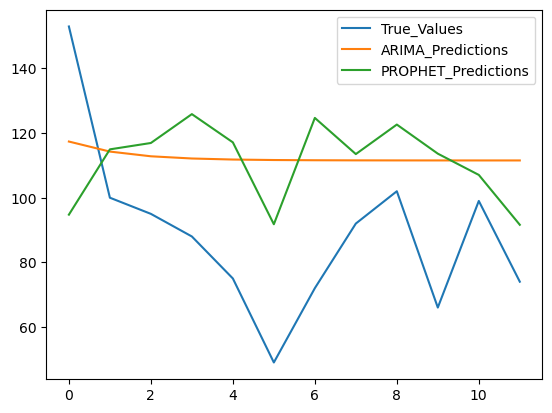

In [13]:
pred_df.plot()

# Fitted and Predicted Values

In [14]:
data_arima = np.array(final_df_monthly['Counts'])
modl = pm.auto_arima(data_arima, start_p=1, start_q=1, start_P=1, start_Q=1,
                     max_p=5, max_q=5, max_P=5, max_Q=5, seasonal=True,
                     stepwise=True, suppress_warnings=True, D=10, max_D=10,
                     error_action='ignore')
preds_arima = modl.predict(n_periods=12, return_conf_int=False)

In [15]:
m = prophet.Prophet()
data_prophet = final_df_monthly
data_prophet.reset_index(inplace=True)
data_prophet = data_prophet.rename(columns = {'Issue Date':'ds'})
data_prophet['y'] = final_df_monthly['Counts']
m.fit(data_prophet)
future = m.make_future_dataframe(periods=12, include_history = False)
forecast = m.predict(future)
preds_prophet = forecast[["ds","yhat"]]

15:29:59 - cmdstanpy - INFO - Chain [1] start processing
15:29:59 - cmdstanpy - INFO - Chain [1] done processing


In [16]:
future = m.make_future_dataframe(periods=12, include_history = True)

In [17]:
output = future
output = output.rename(columns = {"ds":"time"})
preds_prophet = preds_prophet.rename(columns = {"ds":"time", "yhat":"prophet_pred"})
preds_prophet["arima_pred"] = preds_arima
output = output.merge(preds_prophet, how = "outer", on = "time")
prep_final_df = final_df_monthly
prep_final_df = prep_final_df.rename(columns = {"Issue Date":"time"})
output = output.merge(prep_final_df, how = "outer", on = "time")
# output = output.drop(columns = ["level_0", "index"])
output = output.rename(columns = {"Counts": "values"})

In [18]:
display(output)

,time,prophet_pred,arima_pred,values
0,2013-07-01,NaN,NaN,26.0
1,2013-08-01,NaN,NaN,104.0
2,2013-09-01,NaN,NaN,111.0
3,2013-10-01,NaN,NaN,112.0
4,2013-11-01,NaN,NaN,131.0
...,...,...,...,...
127,2023-06-09,84.976200,108.722522,NaN
128,2023-06-10,86.798711,108.783239,NaN
129,2023-06-11,88.911647,108.813108,NaN
130,2023-06-12,91.258060,108.827801,NaN


In [19]:
output.to_csv("../../data/time_series/line_graph_monthly_data.csv")

In [20]:
modl

ARIMA(order=(1, 0, 0), scoring_args={}, suppress_warnings=True)